In [14]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [15]:
warnings.filterwarnings("ignore")

In [16]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [17]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [18]:
# Linear Interpolation 
def ends_filler(column):
    if  column.dtype.kind in ['i', 'f']:
            column = first_filler(column)
            column = last_filler(column)
    return column

def first_filler(column):
    if pd.isnull(column.at[0]) or np.isnan(column.at[0]):
        size = len(column) -1
        first_valid_index = 0
        while first_valid_index <= size and (pd.isnull(column.at[first_valid_index]) or np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > size:
            column.at[0] = 0.0
        else:
            column.at[0] = column.at[first_valid_index]
    return column
    
def last_filler(column):
    if pd.isnull(column.at[len(column) -1]) or np.isnan(column.at[len(column) -1]):  
        last_valid_index = len(column) -1
        while last_valid_index >= 0 and (pd.isnull(column.at[last_valid_index]) or np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < 0:
            column.at[len(column) -1] = 0.0
        else:
            column.at[len(column) -1] = column.at[last_valid_index]
    return column
    
def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def linear_filler(column):
    if column.isnull().any():
        for i, value in enumerate(column):
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                linear_a = (column.at[end] - column.at[start])/(end - start)
                linear_b = column.at[start] - linear_a*start
                for x in gap:
                    column.at[x] = linear_a*x + linear_b
    return column 


In [19]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = ends_filler(df[col])
                df[col] = linear_filler(df[col]) 
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 90) #2 anos
            i += 1
        return df

In [20]:
df = read_csv_replace_missing_by_polynomial('selic.csv', 0, 0)
df

,Ano,Taxa Selic (%)
0,04/06/1986,0.099956
1,05/06/1986,0.100184
2,06/06/1986,0.100388
3,09/06/1986,0.100594
4,10/06/1986,0.100782
...,...,...
9284,20/06/2023,0.050447
9285,21/06/2023,0.050445
9286,22/06/2023,0.050443
9287,23/06/2023,0.050440


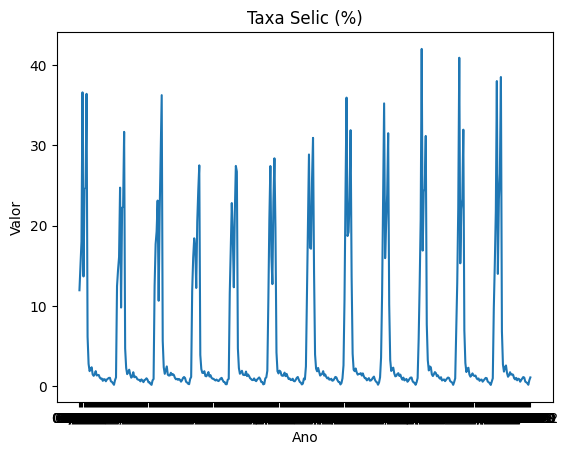

,Taxa Selic (%)
Ano,
01/1987,11.954507
01/1988,14.848758
01/1989,18.022293
01/1990,36.593304
01/1991,13.672578
...,...
12/2018,0.494916
12/2019,0.379077
12/2020,0.187466


In [21]:
df['Ano'] = df['Ano'].str[3:]
df_month = df.groupby(df['Ano']).sum()
df_month

In [22]:
df_month.index = df_month.index.str[3:]
df_month.sort_index(ascending=True, inplace=True)
df_month

,Taxa Selic (%)
Ano,
1986,2.478570
1986,1.934007
1986,2.606643
1986,6.814026
1986,3.566183
...,...
2023,1.159426
2023,0.906165
2023,1.104578


In [23]:
df_month.index = df_month.index.astype(int)
df_mo_2003 = df_month[df_month.index >= 2003] 
df_mo_2003

,Taxa Selic (%)
Ano,
2003,1.624436
2003,1.442077
2003,1.882905
2003,1.355304
2003,1.633055
...,...
2023,1.159426
2023,0.906165
2023,1.104578


In [24]:
df_mo_2003.to_csv('2003_mo_selic.csv', index=True)

In [25]:
df_year = df.groupby(df['Ano']).sum()
df_year

,Taxa Selic (%)
Ano,
01/1987,11.954507
01/1988,14.848758
01/1989,18.022293
01/1990,36.593304
01/1991,13.672578
...,...
12/2018,0.494916
12/2019,0.379077
12/2020,0.187466


In [26]:
df_2003 = df_year[df_year.index >= 2003]
df_2003

TypeError: '>=' not supported between instances of 'str' and 'int'

In [ ]:
df_2003.to_csv('2003_01_selic.csv', index=True)

In [ ]:
df_2014 = df_year[df_year.index >= 2014]
df_2014

In [ ]:
df_2014.to_csv('2014_01_selic.csv', index=True)

In [ ]:
df_2008 = df_year[df_year.index >= 2008]
df_2008

In [ ]:
df_2008.to_csv('2008_01_selic.csv', index=True)